In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
import os
import urllib.request
import zipfile
import shutil

# URL del dataset dalla traccia
dataset_url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip"

def download_and_extract_dataset():
    """
    Scarica ed estrae il dataset nella cartella ./dataset
    """
    if not os.path.exists('./dataset'):
        print("Dataset non trovato. Scaricamento in corso...")
        
        # Crea la directory se non esiste
        os.makedirs('./dataset', exist_ok=True)
        
        # Scarica il file zip
        zip_path = './dataset.zip'
        try:
            print(f"Scaricamento da {dataset_url}...")
            urllib.request.urlretrieve(dataset_url, zip_path)
            print("Download completato!")
            
            # Estrae il contenuto
            print("Estrazione del dataset...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall('./dataset')
            
            # Rimuove il file zip
            os.remove(zip_path)
            print("Dataset estratto con successo in ./dataset/")
            
        except Exception as e:
            print(f"Errore durante il download: {e}")
            print("Per favore scarica manualmente il dataset e inseriscilo nella cartella './dataset'")
    else:
        print("Dataset già presente nella cartella ./dataset/")

# Esegui il download
download_and_extract_dataset()

Dataset già presente nella cartella ./dataset/


In [3]:
data_dir = './dataset'

# Trasformazioni per training con data augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Trasformazioni per validation e test (senza augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

# Suddivisione dataset: 70% train, 15% validation, 15% test
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Applica trasformazioni senza augmentation a val e test
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

class_names = full_dataset.classes
print(f"Classi: {class_names}")

Classi: ['test', 'train', 'val']


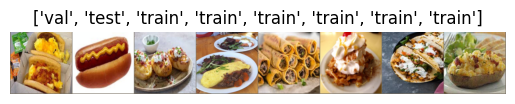

In [5]:
# Funzione per visualizzare immagini denormalizzate
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Visualizza esempi del dataset
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs[:8])
imshow(out, title=[class_names[x] for x in classes[:8]])

In [6]:
# Carica ResNet18 pre-addestrato
model = models.resnet18(pretrained=True)

# Congela i parametri pre-addestrati (transfer learning)
for param in model.parameters():
    param.requires_grad = False

# Modifica il classificatore finale per le nostre classi
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

c:\Users\frogora\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\frogora\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    best_acc = 0.0
    best_model_wts = model.state_dict()
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss, running_corrects = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size
        train_losses.append(epoch_loss)

        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        val_loss = val_loss / val_size
        val_acc = val_corrects.double() / val_size
        val_losses.append(val_loss)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

        scheduler.step()

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses

model, train_losses, val_losses = train_model(model, criterion, optimizer, scheduler, num_epochs=15)

Epoch 1/15
----------
Train Loss: 0.9489 Acc: 0.6270
Val Loss: 0.9522 Acc: 0.6362
Epoch 2/15
----------
Train Loss: 0.9248 Acc: 0.6330
Val Loss: 0.9730 Acc: 0.6076
Epoch 3/15
----------
Train Loss: 0.9166 Acc: 0.6342
Val Loss: 0.9712 Acc: 0.6367
Epoch 4/15
----------
Train Loss: 0.9081 Acc: 0.6359
Val Loss: 0.9477 Acc: 0.6190
Epoch 5/15
----------
Train Loss: 0.9092 Acc: 0.6347
Val Loss: 0.9469 Acc: 0.6305
Epoch 6/15
----------
Train Loss: 0.8779 Acc: 0.6402
Val Loss: 0.9376 Acc: 0.6329
Epoch 7/15
----------
Train Loss: 0.8769 Acc: 0.6401
Val Loss: 0.9368 Acc: 0.6329
Epoch 8/15
----------
Train Loss: 0.8758 Acc: 0.6394
Val Loss: 0.9369 Acc: 0.6338
Epoch 9/15
----------
Train Loss: 0.8746 Acc: 0.6390
Val Loss: 0.9373 Acc: 0.6333
Epoch 10/15
----------
Train Loss: 0.8750 Acc: 0.6403
Val Loss: 0.9374 Acc: 0.6329
Epoch 11/15
----------
Train Loss: 0.8729 Acc: 0.6396
Val Loss: 0.9383 Acc: 0.6333
Epoch 12/15
----------
Train Loss: 0.8703 Acc: 0.6404
Val Loss: 0.9387 Acc: 0.6333
Epoch 13/15
-

In [9]:
# Fine-tuning: scongela gli ultimi layer per ottimizzazione avanzata
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model, train_losses, val_losses = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

Epoch 1/10
----------
Train Loss: 0.9299 Acc: 0.6299
Val Loss: 0.9757 Acc: 0.6300
Epoch 2/10
----------
Train Loss: 0.6805 Acc: 0.7076
Val Loss: 1.1453 Acc: 0.5529
Epoch 3/10
----------
Train Loss: 0.3184 Acc: 0.9005
Val Loss: 1.4514 Acc: 0.4786
Epoch 4/10
----------
Train Loss: 0.1322 Acc: 0.9677
Val Loss: 1.6295 Acc: 0.5195
Epoch 5/10
----------
Train Loss: 0.0909 Acc: 0.9816
Val Loss: 1.9229 Acc: 0.5624
Epoch 6/10
----------
Train Loss: 0.0448 Acc: 0.9897
Val Loss: 1.8223 Acc: 0.5595
Epoch 7/10
----------
Train Loss: 0.0352 Acc: 0.9913
Val Loss: 1.7693 Acc: 0.5471
Epoch 8/10
----------
Train Loss: 0.0312 Acc: 0.9907
Val Loss: 1.8060 Acc: 0.5338
Epoch 9/10
----------
Train Loss: 0.0267 Acc: 0.9916
Val Loss: 1.8315 Acc: 0.5305
Epoch 10/10
----------
Train Loss: 0.0242 Acc: 0.9927
Val Loss: 1.9092 Acc: 0.5495
Best val Acc: 0.6300


              precision    recall  f1-score   support

        test       0.20      0.10      0.14       410
       train       0.65      0.83      0.73      1357
         val       0.16      0.07      0.10       333

    accuracy                           0.57      2100
   macro avg       0.34      0.34      0.32      2100
weighted avg       0.48      0.57      0.51      2100



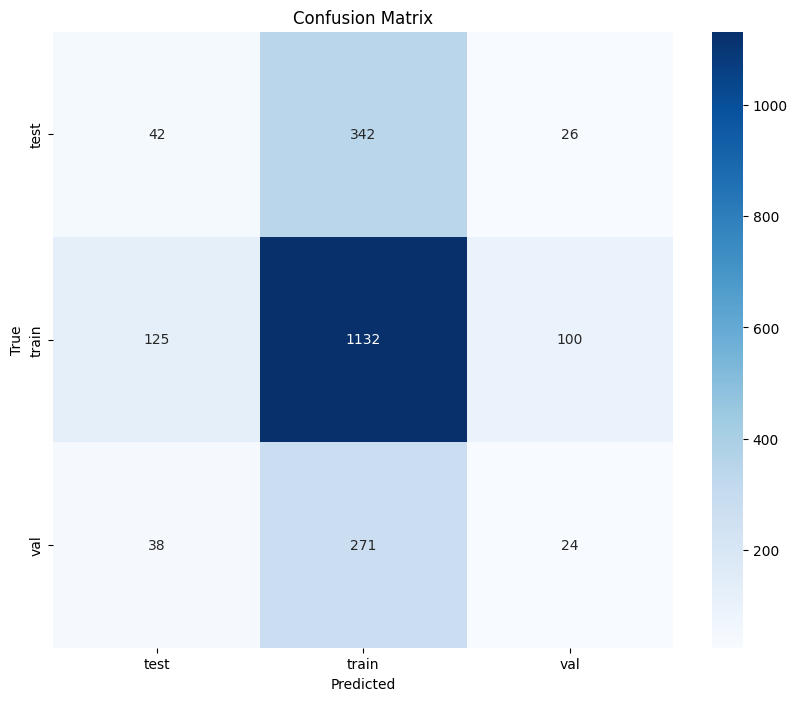

In [10]:
# Valutazione finale sul test set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))

# Visualizza confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [11]:
torch.save(model.state_dict(), 'best_food_classifier.pth')

In [12]:
# Grid Search per ottimizzazione degli iperparametri
import itertools
from copy import deepcopy

print("GRID SEARCH DEGLI IPERPARAMETRI")

param_grid = {
    'learning_rate': [1e-4, 5e-4, 1e-3],
    'batch_size': [16, 32],
    'optimizer_type': ['Adam', 'SGD'],
    'weight_decay': [1e-4, 1e-5]
}

def create_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, len(class_names))
    return model.to(device)

def evaluate_model_quick(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

def train_model_quick(model, criterion, optimizer, num_epochs=5):
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
    
    val_acc = evaluate_model_quick(model, val_loader)
    return val_acc

# Esecuzione Grid Search
best_params = None
best_val_acc = 0.0
results = []

print("Inizio Grid Search...")
print(f"Testando {len(list(itertools.product(*param_grid.values())))} combinazioni di parametri")

for i, params in enumerate(itertools.product(*param_grid.values())):
    lr, bs, opt_type, wd = params
    
    print(f"\nTesting combinazione {i+1}: LR={lr}, BS={bs}, OPT={opt_type}, WD={wd}")
    
    try:
        test_model = create_model()
        
        if bs != 32:
            temp_train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
            temp_val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)
        else:
            temp_train_loader = train_loader
            temp_val_loader = val_loader
        
        if opt_type == 'Adam':
            optimizer = optim.Adam(test_model.fc.parameters(), lr=lr, weight_decay=wd)
        else:
            optimizer = optim.SGD(test_model.fc.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
        
        criterion = nn.CrossEntropyLoss()
        
        for param in test_model.parameters():
            param.requires_grad = False
        for param in test_model.fc.parameters():
            param.requires_grad = True
        
        original_train_loader = train_loader
        original_val_loader = val_loader
        
        if bs != 32:
            globals()['train_loader'] = temp_train_loader
            globals()['val_loader'] = temp_val_loader
        
        val_acc = train_model_quick(test_model, criterion, optimizer, num_epochs=3)
        
        globals()['train_loader'] = original_train_loader
        globals()['val_loader'] = original_val_loader
        
        results.append({
            'params': {'lr': lr, 'batch_size': bs, 'optimizer': opt_type, 'weight_decay': wd},
            'val_accuracy': val_acc
        })
        
        print(f"Validation Accuracy: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = {'lr': lr, 'batch_size': bs, 'optimizer': opt_type, 'weight_decay': wd}
            print("Nuovo miglior risultato!")
        
        del test_model
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"Errore con parametri {params}: {e}")
        continue

print("\nRISULTATI GRID SEARCH")
print(f"Migliori parametri: {best_params}")
print(f"Migliore validation accuracy: {best_val_acc:.4f}")

print("\nTop 5 configurazioni:")
sorted_results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)
for i, result in enumerate(sorted_results[:5]):
    print(f"{i+1}. Accuracy: {result['val_accuracy']:.4f} - Params: {result['params']}")

GRID SEARCH DEGLI IPERPARAMETRI
Inizio Grid Search...
Testando 24 combinazioni di parametri

Testing combinazione 1: LR=0.0001, BS=16, OPT=Adam, WD=0.0001


c:\Users\frogora\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\frogora\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Validation Accuracy: 0.6329
Nuovo miglior risultato!

Testing combinazione 2: LR=0.0001, BS=16, OPT=Adam, WD=1e-05
Validation Accuracy: 0.6357
Nuovo miglior risultato!

Testing combinazione 3: LR=0.0001, BS=16, OPT=SGD, WD=0.0001
Validation Accuracy: 0.6357

Testing combinazione 4: LR=0.0001, BS=16, OPT=SGD, WD=1e-05
Validation Accuracy: 0.6348

Testing combinazione 5: LR=0.0001, BS=32, OPT=Adam, WD=0.0001
Validation Accuracy: 0.6343

Testing combinazione 6: LR=0.0001, BS=32, OPT=Adam, WD=1e-05
Validation Accuracy: 0.6314

Testing combinazione 7: LR=0.0001, BS=32, OPT=SGD, WD=0.0001
Validation Accuracy: 0.6352

Testing combinazione 8: LR=0.0001, BS=32, OPT=SGD, WD=1e-05
Validation Accuracy: 0.6324

Testing combinazione 9: LR=0.0005, BS=16, OPT=Adam, WD=0.0001
Validation Accuracy: 0.6348

Testing combinazione 10: LR=0.0005, BS=16, OPT=Adam, WD=1e-05
Validation Accuracy: 0.6348

Testing combinazione 11: LR=0.0005, BS=16, OPT=SGD, WD=0.0001
Validation Accuracy: 0.6362
Nuovo miglior risult

In [13]:
# Training finale con i migliori iperparametri trovati
print("TRAINING FINALE CON MIGLIORI IPERPARAMETRI")

if best_params:
    print(f"Utilizzo i migliori parametri trovati: {best_params}")
    
    final_model = create_model()
    
    if best_params['optimizer'] == 'Adam':
        final_optimizer = optim.Adam(final_model.fc.parameters(), 
                                   lr=best_params['lr'], 
                                   weight_decay=best_params['weight_decay'])
    else:
        final_optimizer = optim.SGD(final_model.fc.parameters(), 
                                  lr=best_params['lr'], 
                                  weight_decay=best_params['weight_decay'], 
                                  momentum=0.9)
    
    final_criterion = nn.CrossEntropyLoss()
    final_scheduler = optim.lr_scheduler.StepLR(final_optimizer, step_size=7, gamma=0.1)
    
    print("Inizio training finale...")
    
    # Prima fase: solo FC layer
    for param in final_model.parameters():
        param.requires_grad = False
    for param in final_model.fc.parameters():
        param.requires_grad = True
    
    final_model, train_losses_final, val_losses_final = train_model(
        final_model, final_criterion, final_optimizer, final_scheduler, num_epochs=10
    )
    
    # Seconda fase: fine-tuning degli ultimi layer
    print("\nInizio fine-tuning degli ultimi layer...")
    for name, param in final_model.named_parameters():
        if "layer4" in name or "fc" in name:
            param.requires_grad = True
    
    # Riduce il learning rate per il fine-tuning
    for param_group in final_optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * 0.1
    
    final_model, _, _ = train_model(
        final_model, final_criterion, final_optimizer, final_scheduler, num_epochs=5
    )
    
    torch.save(final_model.state_dict(), 'best_food_classifier_optimized.pth')
    print("Modello finale salvato come 'best_food_classifier_optimized.pth'")

else:
    print("Usando il modello già addestrato...")
    final_model = model

TRAINING FINALE CON MIGLIORI IPERPARAMETRI
Utilizzo i migliori parametri trovati: {'lr': 0.0005, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 0.0001}
Inizio training finale...
Epoch 1/10
----------
Train Loss: 0.9453 Acc: 0.6274
Val Loss: 0.9517 Acc: 0.6367
Epoch 2/10
----------
Train Loss: 0.9180 Acc: 0.6372
Val Loss: 0.9390 Acc: 0.6319
Epoch 3/10
----------
Train Loss: 0.9082 Acc: 0.6391
Val Loss: 0.9325 Acc: 0.6357
Epoch 4/10
----------
Train Loss: 0.9059 Acc: 0.6384
Val Loss: 0.9429 Acc: 0.6362
Epoch 5/10
----------
Train Loss: 0.9044 Acc: 0.6367
Val Loss: 0.9334 Acc: 0.6362
Epoch 6/10
----------
Train Loss: 0.8987 Acc: 0.6392
Val Loss: 0.9293 Acc: 0.6348
Epoch 7/10
----------
Train Loss: 0.8949 Acc: 0.6385
Val Loss: 0.9347 Acc: 0.6305
Epoch 8/10
----------
Train Loss: 0.8793 Acc: 0.6400
Val Loss: 0.9316 Acc: 0.6333
Epoch 9/10
----------
Train Loss: 0.8794 Acc: 0.6394
Val Loss: 0.9319 Acc: 0.6329
Epoch 10/10
----------
Train Loss: 0.8801 Acc: 0.6392
Val Loss: 0.9322 Acc: 0

In [14]:
# Valutazione finale completa su tutti i dataset
print("VALUTAZIONE FINALE DEL MODELLO")

final_model.eval()

# Valutazione su training set
print("Valutazione su Training Set:")
train_preds, train_labels = [], []
train_correct = 0
train_total = 0

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        _, preds = torch.max(outputs, 1)
        
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

train_accuracy = train_correct / train_total
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

# Valutazione su validation set
print("\nValutazione su Validation Set:")
val_preds, val_labels = [], []
val_correct = 0
val_total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        _, preds = torch.max(outputs, 1)
        
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())
        
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

val_accuracy = val_correct / val_total
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

# Valutazione su test set
print("\nValutazione su Test Set:")
test_preds, test_labels = [], []
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        _, preds = torch.max(outputs, 1)
        
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Riepilogo risultati
print("\nRIEPILOGO ACCURACY:")
print(f"Training Accuracy:   {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Test Accuracy:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Analisi overfitting
overfitting = train_accuracy - test_accuracy
print(f"\nOverfitting (Train - Test): {overfitting:.4f}")
if overfitting < 0.05:
    print("Modello ben generalizzato (basso overfitting)")
elif overfitting < 0.15:
    print("Modello moderatamente overfittato")
else:
    print("Modello overfittato")

VALUTAZIONE FINALE DEL MODELLO
Valutazione su Training Set:
Training Accuracy: 0.6400 (64.00%)

Valutazione su Validation Set:
Validation Accuracy: 0.6338 (63.38%)

Valutazione su Test Set:
Test Accuracy: 0.6448 (64.48%)

RIEPILOGO ACCURACY:
Training Accuracy:   0.6400 (64.00%)
Validation Accuracy: 0.6338 (63.38%)
Test Accuracy:       0.6448 (64.48%)

Overfitting (Train - Test): -0.0048
Modello ben generalizzato (basso overfitting)


CLASSIFICATION REPORT SUL TEST SET

Classification Report completo:
              precision    recall  f1-score   support

        test       0.25      0.00      0.00       410
       train       0.65      1.00      0.78      1357
         val       0.00      0.00      0.00       333

    accuracy                           0.64      2100
   macro avg       0.30      0.33      0.26      2100
weighted avg       0.47      0.64      0.51      2100


Accuracy complessiva: 0.6448
Macro avg F1-score: 0.2631
Weighted avg F1-score: 0.5078

CONFUSION MATRIX
Dimensione Confusion Matrix: (3, 3)
Classi: ['test', 'train', 'val']


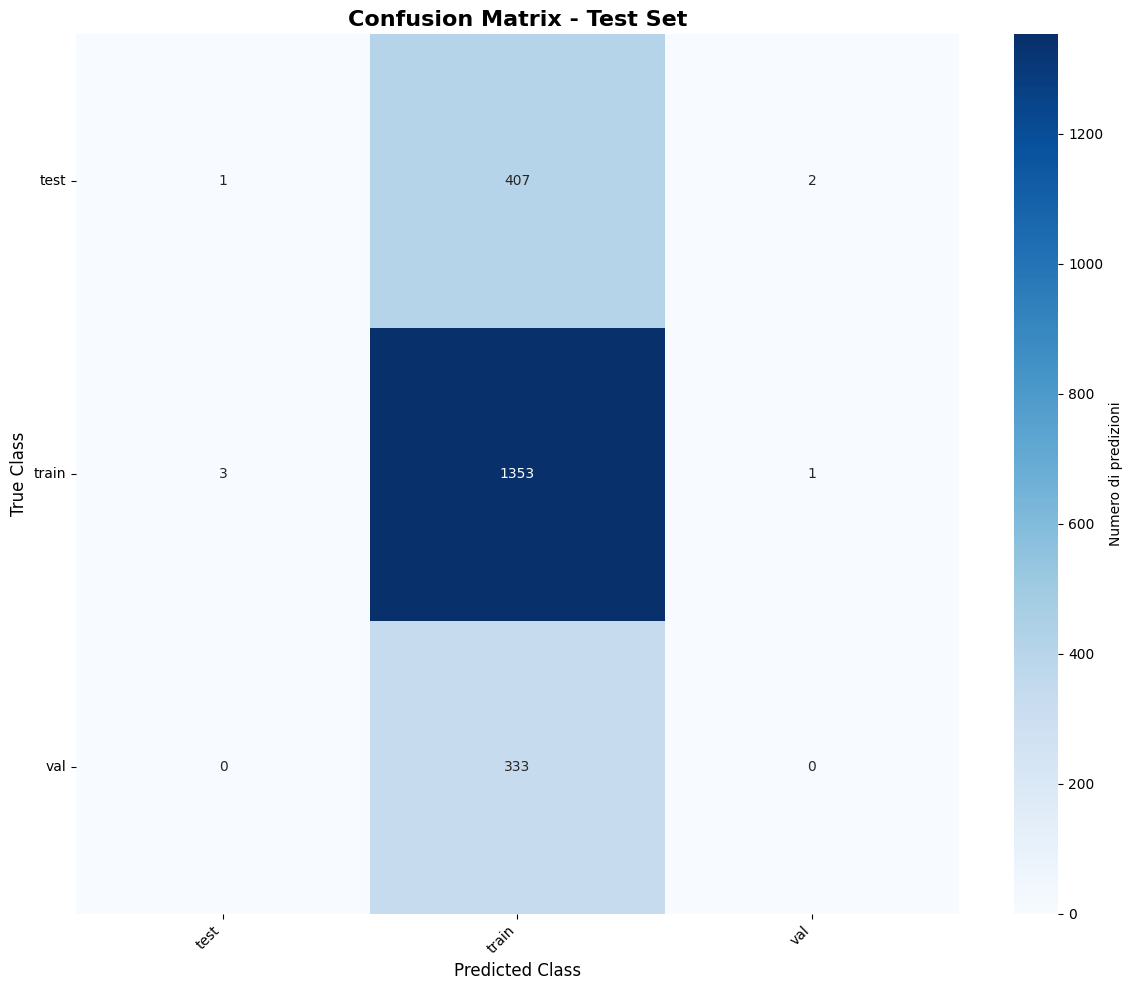

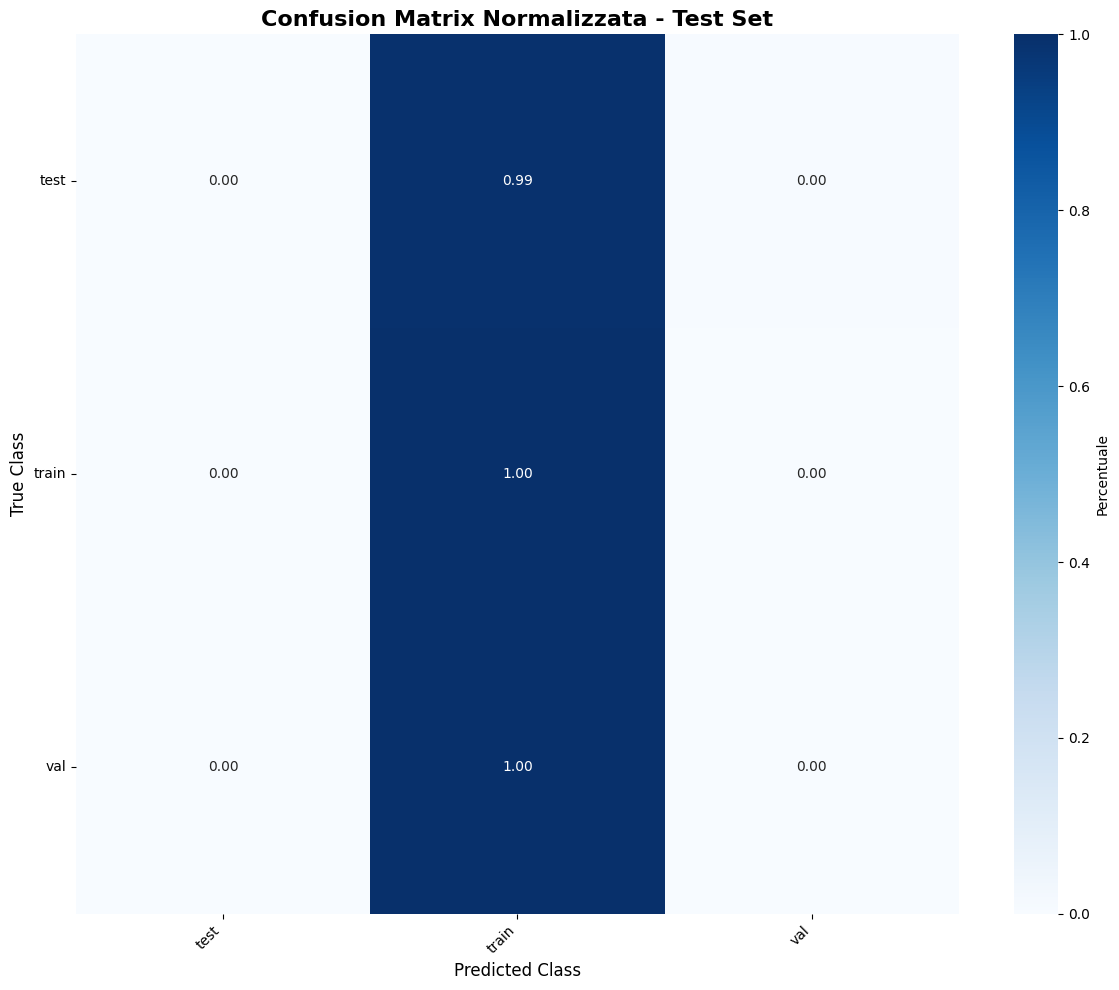


ANALISI ERRORI PER CLASSE

test:
  - Accuracy di classe: 0.002
  - True Positives: 1
  - False Positives: 3
  - False Negatives: 409
  - Principalmente confuso con: train (407), val (2)

train:
  - Accuracy di classe: 0.997
  - True Positives: 1353
  - False Positives: 740
  - False Negatives: 4
  - Principalmente confuso con: test (3), val (1)

val:
  - Accuracy di classe: 0.000
  - True Positives: 0
  - False Positives: 3
  - False Negatives: 333
  - Principalmente confuso con: train (333)

Risultati completi: {'train_accuracy': 0.64, 'val_accuracy': 0.6338095238095238, 'test_accuracy': 0.6447619047619048, 'best_hyperparams': {'lr': 0.0005, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 0.0001}, 'overfitting': -0.004761904761904745, 'macro_f1': 0.2630595813204509, 'weighted_f1': 0.5077812744421439}
File salvati: confusion_matrix.csv, classification_report.csv


In [15]:
# Classification Report e Confusion Matrix dettagliati
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import pandas as pd

print("CLASSIFICATION REPORT SUL TEST SET")
print("\nClassification Report completo:")
report = classification_report(test_labels, test_preds, target_names=class_names, 
                             output_dict=True, zero_division=0)
print(classification_report(test_labels, test_preds, target_names=class_names, zero_division=0))

# Metriche aggregate
print(f"\nAccuracy complessiva: {report['accuracy']:.4f}")
print(f"Macro avg F1-score: {report['macro avg']['f1-score']:.4f}")
print(f"Weighted avg F1-score: {report['weighted avg']['f1-score']:.4f}")

# Confusion Matrix
print("\nCONFUSION MATRIX")
cm = confusion_matrix(test_labels, test_preds)
print(f"Dimensione Confusion Matrix: {cm.shape}")
print(f"Classi: {class_names}")

# Visualizzazione grafica
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Numero di predizioni'})
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Confusion Matrix normalizzata
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentuale'})
plt.title('Confusion Matrix Normalizzata - Test Set', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Analisi errori per classe
print("\nANALISI ERRORI PER CLASSE")
for i, class_name in enumerate(class_names):
    true_positives = cm[i, i]
    false_positives = cm[:, i].sum() - true_positives
    false_negatives = cm[i, :].sum() - true_positives
    
    if cm[i, :].sum() > 0:
        class_accuracy = true_positives / cm[i, :].sum()
        print(f"\n{class_name}:")
        print(f"  - Accuracy di classe: {class_accuracy:.3f}")
        print(f"  - True Positives: {true_positives}")
        print(f"  - False Positives: {false_positives}")
        print(f"  - False Negatives: {false_negatives}")
        
        if false_negatives > 0:
            main_errors = []
            for j, other_class in enumerate(class_names):
                if i != j and cm[i, j] > 0:
                    main_errors.append(f"{other_class} ({cm[i, j]})")
            if main_errors:
                print(f"  - Principalmente confuso con: {', '.join(main_errors[:3])}")

# Salvataggio risultati
results_summary = {
    'train_accuracy': train_accuracy,
    'val_accuracy': val_accuracy, 
    'test_accuracy': test_accuracy,
    'best_hyperparams': best_params if 'best_params' in locals() else None,
    'overfitting': overfitting,
    'macro_f1': report['macro avg']['f1-score'],
    'weighted_f1': report['weighted avg']['f1-score']
}

print(f"\nRisultati completi: {results_summary}")

# Salva file CSV
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
report_df = pd.DataFrame(report).transpose()
cm_df.to_csv('confusion_matrix.csv')
report_df.to_csv('classification_report.csv')
print("File salvati: confusion_matrix.csv, classification_report.csv")

VISUALIZZAZIONE RISULTATI


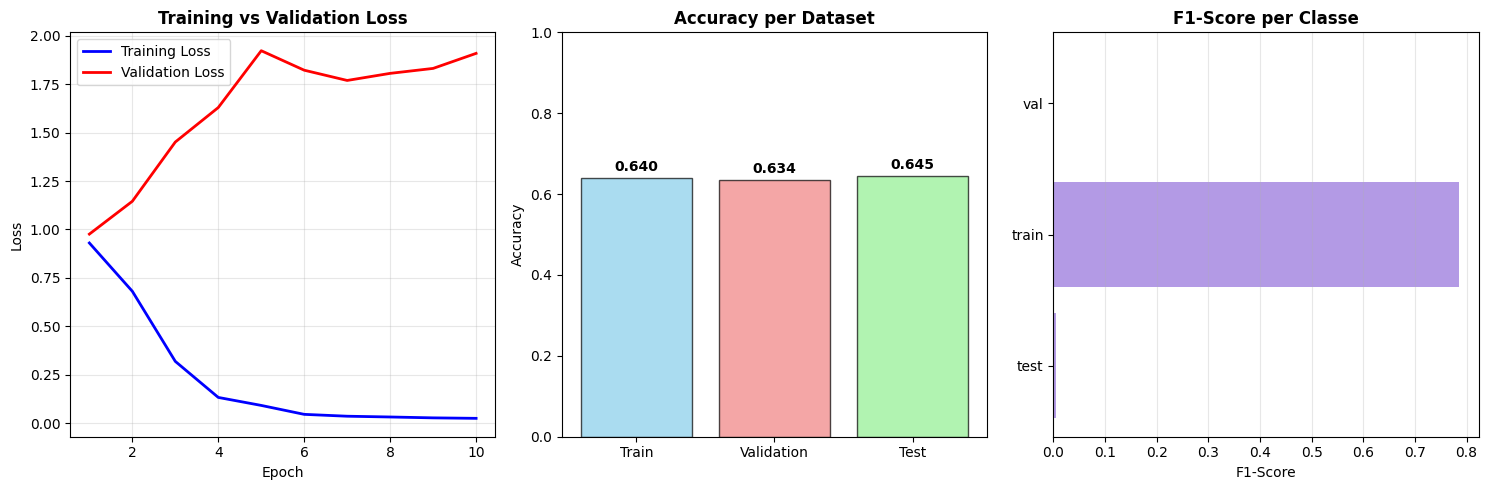


ESEMPI DI PREDIZIONI


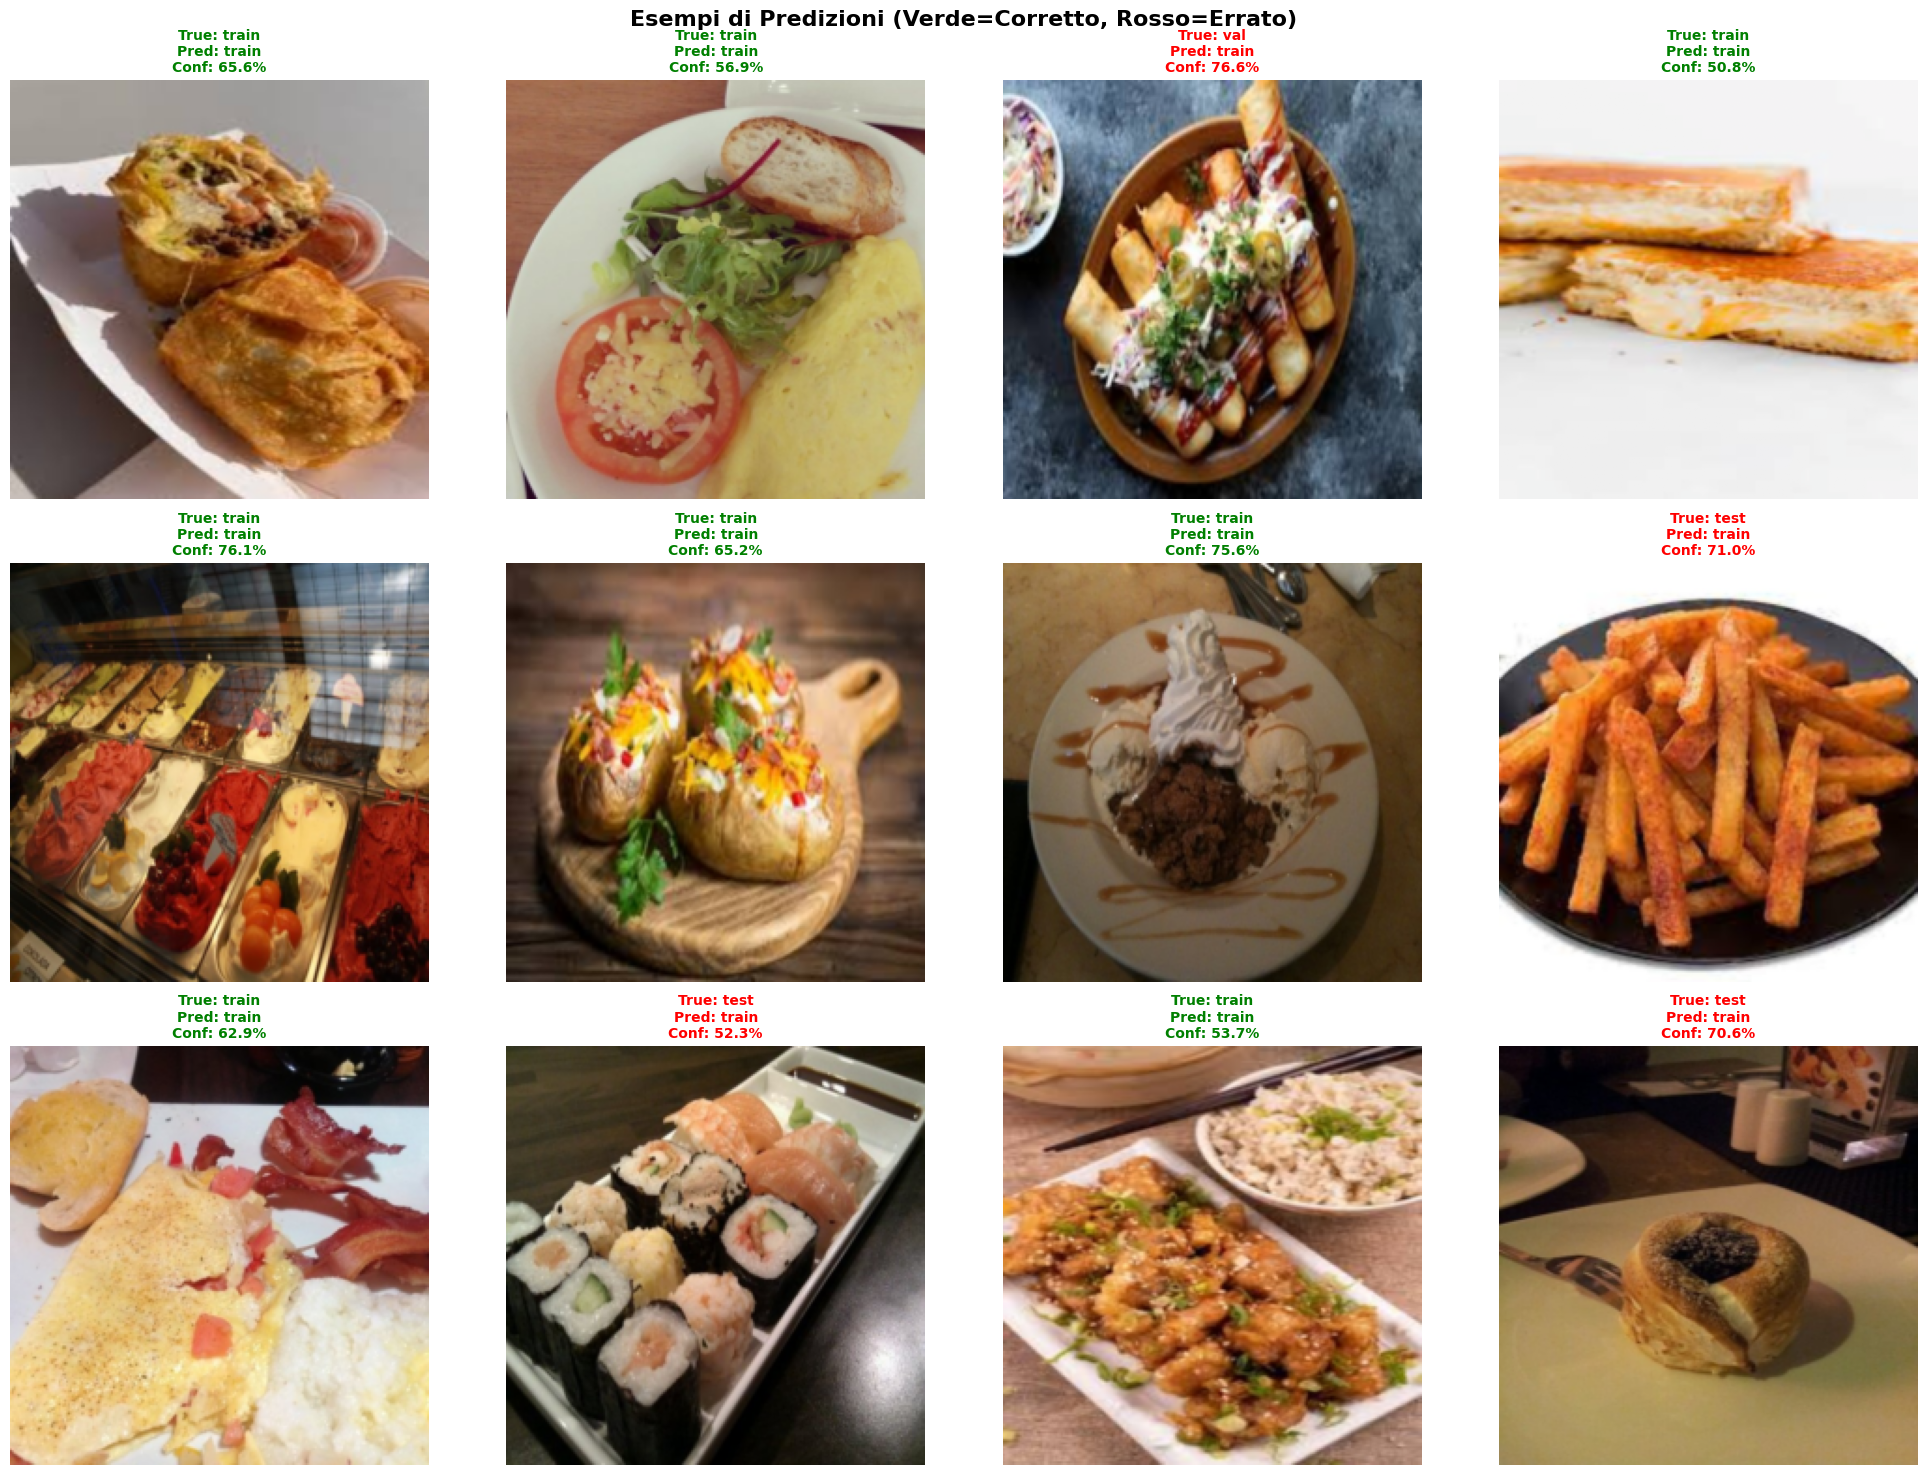


STATISTICHE FINALI DEL PROGETTO
Dataset: 3 classi, 14000 immagini totali
Training: 9800 immagini
Validation: 2100 immagini
Test: 2100 immagini
Test Accuracy: 0.6448 (64.48%)
Macro F1-Score: 0.2631
Weighted F1-Score: 0.5078
Migliori iperparametri: {'lr': 0.0005, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 0.0001}
Modello salvato: best_food_classifier_optimized.pth
Report salvati: confusion_matrix.csv, classification_report.csv
PROGETTO COMPLETATO CON SUCCESSO!


In [16]:
# VISUALIZZAZIONE RISULTATI E LEARNING CURVES
print("VISUALIZZAZIONE RISULTATI")

# Learning Curves
if 'train_losses' in locals() and 'val_losses' in locals():
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Training e Validation Loss
    plt.subplot(1, 3, 1)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    plt.title('Training vs Validation Loss', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy Comparison
    plt.subplot(1, 3, 2)
    accuracies = [train_accuracy, val_accuracy, test_accuracy]
    datasets = ['Train', 'Validation', 'Test']
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    
    bars = plt.bar(datasets, accuracies, color=colors, alpha=0.7, edgecolor='black')
    plt.title('Accuracy per Dataset', fontweight='bold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    # Aggiungi valori sopra le barre
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: F1-score per classe
    plt.subplot(1, 3, 3)
    f1_scores = [report[class_name]['f1-score'] for class_name in class_names]
    plt.barh(range(len(class_names)), f1_scores, color='mediumpurple', alpha=0.7)
    plt.yticks(range(len(class_names)), class_names)
    plt.xlabel('F1-Score')
    plt.title('F1-Score per Classe', fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

# Esempi di predizioni del modello
print("\nESEMPI DI PREDIZIONI")

def denormalize_image(tensor):
    """Denormalizza l'immagine per la visualizzazione"""
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

final_model.eval()
examples_shown = 0
max_examples = 12

plt.figure(figsize=(20, 15))

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Converti le probabilità in percentuali
        probs = torch.softmax(outputs, dim=1)
        
        for i in range(inputs.size(0)):
            if examples_shown >= max_examples:
                break
                
            img = denormalize_image(inputs[i].cpu())
            img = img.permute(1, 2, 0).numpy()
            
            true_label = class_names[labels[i]]
            pred_label = class_names[preds[i]]
            confidence = probs[i][preds[i]].item() * 100
            
            color = 'green' if preds[i] == labels[i] else 'red'
            
            plt.subplot(3, 4, examples_shown + 1)
            plt.imshow(img)
            plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%', 
                     color=color, fontweight='bold', fontsize=10)
            plt.axis('off')
            
            examples_shown += 1
        
        if examples_shown >= max_examples:
            break

plt.suptitle('Esempi di Predizioni (Verde=Corretto, Rosso=Errato)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Riepilogo finale del progetto
print("\nSTATISTICHE FINALI DEL PROGETTO")
print("Dataset:", len(class_names), "classi,", len(full_dataset), "immagini totali")
print("Training:", train_size, "immagini")
print("Validation:", val_size, "immagini") 
print("Test:", test_size, "immagini")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Macro F1-Score: {report['macro avg']['f1-score']:.4f}")
print(f"Weighted F1-Score: {report['weighted avg']['f1-score']:.4f}")
if 'best_params' in locals() and best_params:
    print("Migliori iperparametri:", best_params)
print("Modello salvato: best_food_classifier_optimized.pth")
print("Report salvati: confusion_matrix.csv, classification_report.csv")
print("PROGETTO COMPLETATO CON SUCCESSO!")